# Task 1: Neural Networks

### A1. Provide one research question that you will answer using neural network models and computer vision techniques.

<p>Can a deep learning model accurately classify plant seedlings to assist in weed detection? This research question is relevant in agriculture, where early identification of crops and weeds helps optimize yields. Automated seedling classification can help farmers distinguish crops from weeds, reducing manual work and errors in weed control.</p>

### A2. Define the objectives or goals of the data analysis

<p>This data analysis has two goals. The first goal is to develop a deep learning model that classifies plant seedlings by species. The second goal is to evaluate the model's accuracy and performance to ensure it correctly classifies crops and weeds without misidentifying species. Both goals align with the research question and are represented in the plant data. </p>

### A3. Identify an industry-relevant type of neural network capable of performing an image task that can be trained to produce useful predictions on image sequences on the selected dataset.

<p>The neural network that I will use for plant classification and weed detection task is <b>Convolutional Neural Network (CNN)</b>. </p>

### A4. Justify your choice of neural network in part A3

<p>I selected Convolutional Neural Network (CNN) for multiple reasons. The first reason is CNNs are built to process image data, making them ideal for processing the 4,750 RGB images of plant seedlings in the dataset. The second reason is CNNs automatically learn key features like shape, texture, and patterns, helping to distinguish crops from weeds. The third reason is CNNs handle multi-class classification well, which is important since the dataset includes 12 plant species.  </p>

### B1a. Perform exploratory data analysis on the chosen plant dataset and provide screenshots of the following: visualization for the distribution of the different classes

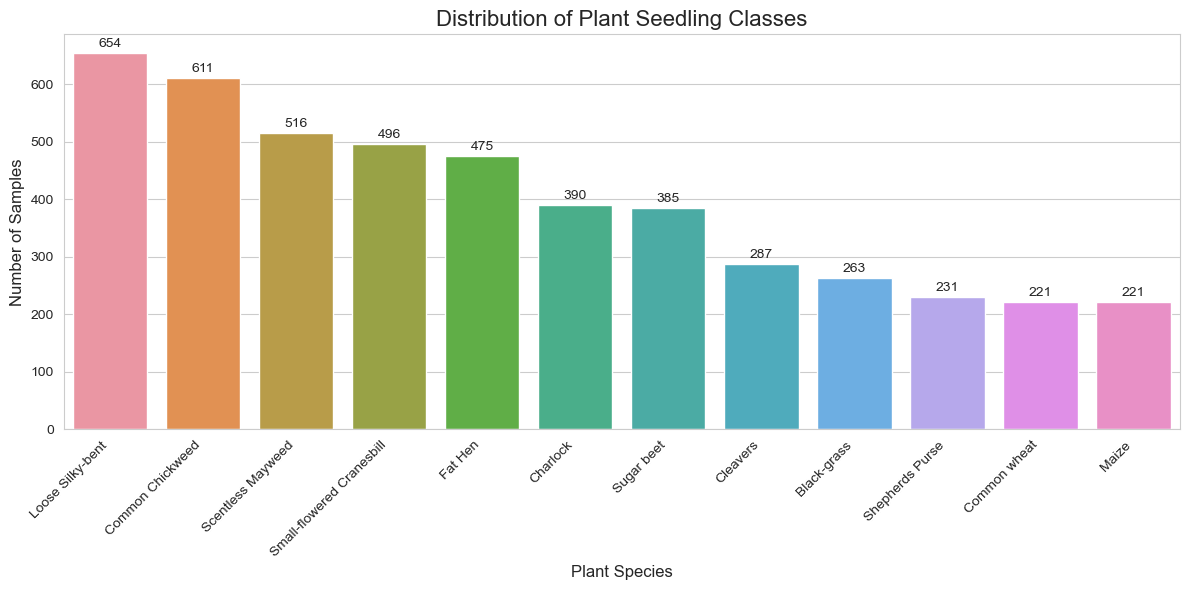

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

np.random.seed(24)  
random.seed(24)  
tf.random.set_seed(24)  

#loading the data
images = np.load("images.npy")
labels = pd.read_csv("labels.csv")

#displaying unique classes and their counts
class_distribution = labels['Label'].value_counts()

#setting up the plot style
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

#creating a bar plot
ax = sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title("Distribution of Plant Seedling Classes", fontsize=16)
plt.xlabel("Plant Species", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(rotation=45, ha='right')

#adding value labels on top of each bar
for i, v in enumerate(class_distribution.values):
    ax.text(i, v + 5, str(v), ha='center', va='bottom')


plt.tight_layout()
plt.show()

<p>In this code, I started by loading the plant images and their labels. Next, I used the value_counts() function to count the number of occurrences for each plant species. Then, I created a bar plot using the barplot() function from Seaborn, with plant species on the x-axis and their respective sample counts on the y-axis. I also added value labels on top of each bar.</p>

<p>There are 12 different plant species in the dataset. The most represented class is "Loose Silky-bent" (654), while "Common wheat" and "Maize" are among the least represented (221 each). The dataset is not balanced because there are some classes that have significantly more images than others. This imbalance may lead to bias during model training.</p>

### B1b. Perform exploratory data analysis on the chosen plant dataset and provide screenshots of the following: sample images with associated labels

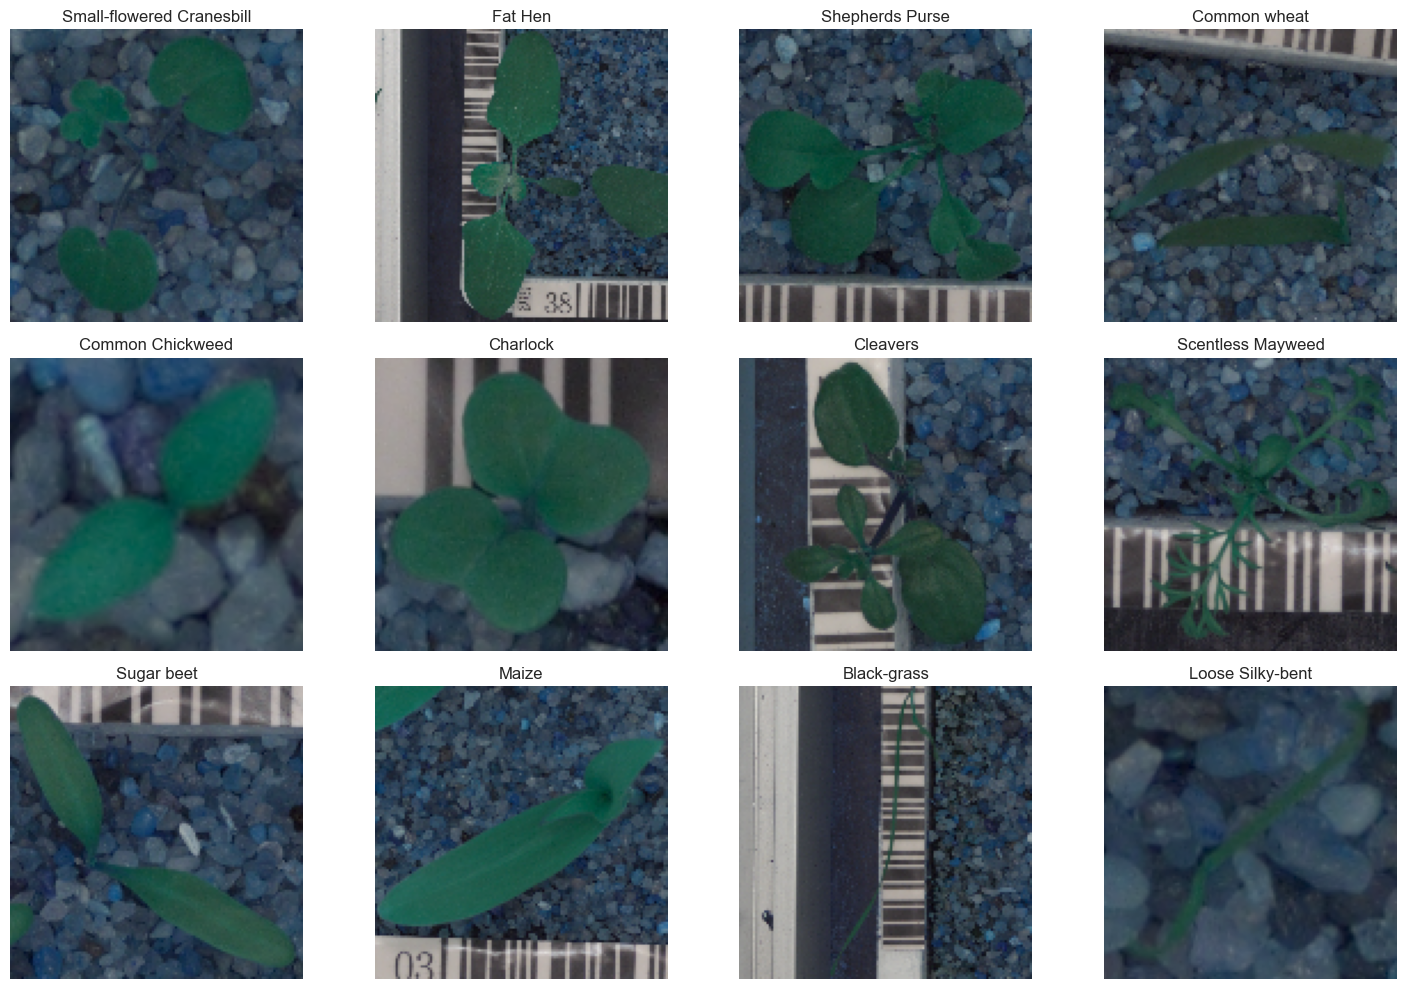

In [2]:
#function to display sample images from different classes
def plot_sample_images(images, labels, num_samples=12):
    unique_classes = labels.iloc[:, 0].unique()
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    for ax, class_name in zip(axes.flatten(), unique_classes):
        class_indices = labels[labels.iloc[:, 0] == class_name].index
        img_idx = random.choice(class_indices)
        ax.imshow(images[img_idx])
        ax.set_title(class_name)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

#displaying sample images from different classes
plot_sample_images(images, labels)

<p>In this code, I created a function named "plot_sample_images" that takes three arguments: images, labels, and num_samples. The goal of this function is to randomly select and display one image from each class. The output shows all 12 unique plant species in the dataset. Each subplot contains a randomly selected image and the name of the plant species.</p>

### B2. Perform data augmentation and justify the steps taken to augment the images

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#extracting label column
labels_column = labels.iloc[:, 0]

class_counts = labels_column.value_counts()

#defining target number of samples for balancing
target_samples = 450

#defining the ImageDataGenerator with augmentations
datagen = ImageDataGenerator(
    rotation_range=25,       
    width_shift_range=0.2,   
    height_shift_range=0.2,  
    shear_range=0.15,        
    zoom_range=0.2,          
    horizontal_flip=True,    
    vertical_flip=False,     
    fill_mode='nearest'  
)

<p>In this section, I performed targeted data augmentation to balance the imbalanced plant dataset by increasing the number of samples for minority classes. I set the target sample count to 450, meaning the minority classes are augmented until they reach this number. Majority classes with over 450 samples remain unchanged. I used the ImageDataGenerator() function from the TensorFlow library to set up the data augmentation pipeline, which applies transformations to images. I set the rotation_range to 25 so the model can recognize plants from different angles, as they appear in real-world settings. I set the width_shift_range and height_shift_range to 0.2 to simulate real-world variations since plants may not always be centered in images. I set the shear_range to 0.15 to introduce small distortions to mimic changes in camera angles. I set zoom_range to 0.2 to simulate different distances of plants from the camera. I set the horizontal_flip to True because plants can grow symmetrically, making horizontal flipping beneficial. I set the vertical_flip to False to avoid vertical flipping since plants grow upwards naturally. I set the fill_mode to "nearest" to fill missing pixels with nearest values.</p>

In [4]:
#creating two lists to store augmented data
augmented_images = []
augmented_labels = []

#augmenting only minority classes
for class_name, count in class_counts.items():
    if count < target_samples:  #only augment if the class has fewer than target_samples
        class_indices = labels[labels_column == class_name].index
        num_needed = target_samples - count  #number of additional images needed

        for _ in range(num_needed):
            img_idx = np.random.choice(class_indices)  #selecting an image randomly
            sample_image = images[img_idx]
            sample_image = np.expand_dims(sample_image, axis=0)  #reshaping for augmentation

            augmented_image = datagen.flow(sample_image, batch_size=1)[0].astype('uint8')[0]
            augmented_images.append(augmented_image)
            augmented_labels.append(class_name)

<p>I created two empty lists to store the augmented data. Then, I used a loop to augment only minority classes with fewer than 450 samples. Inside the loop, each class is checked for samples below 450. If so, the required additional samples are calculated. Next, a random image from the class is selected and augmented using the datagen.flow() function. Then, the augmented image and its corresponding label are added to the lists.</p>

In [5]:
#converting augmented data into NumPy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

#combining augmented data with the original data
balanced_images = np.concatenate((images, augmented_images), axis=0)
balanced_labels = np.concatenate((labels_column, augmented_labels), axis=0)

<p>The augmented data is converted into NumPy arrays and combined with the original data.</p>

In [6]:
#converting the updated labels into a DataFrame
balanced_labels_df = pd.DataFrame(balanced_labels, columns=['label'])

#checking new class distribution
new_class_counts = pd.Series(balanced_labels).value_counts()
print("Class Distribution After Augmentation:\n", new_class_counts)

#saving new dataset
np.save("balanced_images.npy", balanced_images)
balanced_labels_df.to_csv("balanced_labels.csv", index=False)

Class Distribution After Augmentation:
 Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Shepherds Purse              450
Common wheat                 450
Charlock                     450
Cleavers                     450
Sugar beet                   450
Maize                        450
Black-grass                  450
dtype: int64


<p>The updated labels are converted into a DataFrame for easy saving and analysis. I printed the new class distribution after augmentation to verify that all classes in the dataset now have at least 450 samples. I saved the augmented dataset as "balanced_image.npy" and "balanced_labels.csv".</p>

<p>By performing data augmentation for minority classes, it ensures that they are well-represented, reducing class imbalance and preventing biased predictions. Focusing only on underrepresented classes saves computational resources while improving model performance.</p>

### B3. Normalize the images and discuss the steps taken for normalization

In [7]:
#loading the updated balanced dataset
images = np.load("balanced_images.npy")

#loading the updated balanced dataset labels
labels = pd.read_csv("balanced_labels.csv")["label"] 

#converting labels to NumPy array
labels = np.array(labels)

#normalizing the images so pixel values are between 0 and 1
images = images.astype("float32") / 255.0

#verifying the normalization
print("Min pixel value after normalization:", images.min())
print("Max pixel value after normalization:", images.max())
print("Shape of normalized dataset:", images.shape)

Min pixel value after normalization: 0.0
Max pixel value after normalization: 1.0
Shape of normalized dataset: (5902, 128, 128, 3)


<p>In this code, I normalized the images before feeding it into a deep learning model. I started by loading the updated balanced dataset that contains both original and augmented images using the load() function from the NumPy library. Then, I converted the images to a float data type and divided all pixel values by 255 so they fall within the [0,1] range. The minimum and maximum values of the images are 0 and 1, and the dataset shape stays the same, confirming that the normalization is successful. </p>

### B4. Perform a train-validation-test split and justify your selection of the proportions for the split

In [8]:
from sklearn.model_selection import train_test_split

#splitting the data into train (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.30, random_state=12, stratify=labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=12, stratify=y_temp
)

#printing the sizes of each set
print("Training set shape:", X_train.shape, "Labels shape:", y_train.shape)
print("Validation set shape:", X_val.shape, "Labels shape:", y_val.shape)
print("Test set shape:", X_test.shape, "Labels shape:", y_test.shape)

Training set shape: (4131, 128, 128, 3) Labels shape: (4131,)
Validation set shape: (885, 128, 128, 3) Labels shape: (885,)
Test set shape: (886, 128, 128, 3) Labels shape: (886,)


<p>In this code, I split the normalized dataset into train (70%), validation (15%), and test (15%) sets using the train_test_split() function from the sklearn library. The train set gets 70% of the data since deep learning models need plenty of data to learn strong features and generalize effectively. The validation set gets 15% of the data to tune hyperparameters and monitor training performance. This amount balances evaluation accuracy without reducing too much training data. The test set gets 15% of the data, matching the validation set for balanced evaluation. The test set is used only once after training to evaluate the final model on unseen data. I printed the shapes of each dataset to verify that the proportions are correct.</p>

### B5. Encode the target feature appropriately for all your datasets and discuss the steps taken.

In [9]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

#initializing LabelEncoder and fitting on training labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val) 
y_test = label_encoder.transform(y_test)

#converting all labels to one-hot encoding
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

#printing the sizes of each set
print("y_train shape after encoding:", y_train.shape)
print("y_val shape after encoding:", y_val.shape)
print("y_test shape after encoding:", y_test.shape)

y_train shape after encoding: (4131, 12)
y_val shape after encoding: (885, 12)
y_test shape after encoding: (886, 12)


<p>In this code, I encoded the target feature (y_train, y_val, y_test) by converting categorical class labels into one-hot vectors to prepare the data for training. I started by converting categorical class labels into integer values using the LabelEncoder() function. This function assigns a unique integer to each plant species. Next, I converted the integer class labels into one-hot encoded vectors using the to_categorical() function to ensure that each class is uniquely represented without any order. This makes the data suitable for neural networks and ready for training. I printed the shapes for all the datasets to confirm that one-hot encoding was applied successfully. <p>

### B6. Provide a copy of all your datasets

In [10]:
#flattening images by reshaping from (128,128,3) to (49152,)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

#converting label datasets to DataFrame
y_train_csv = pd.DataFrame(y_train)
y_val_csv = pd.DataFrame(y_val)
y_test_csv = pd.DataFrame(y_test)

#saving label datasets as .csv files
y_train_csv.to_csv("y_train.csv", index=False)
y_val_csv.to_csv("y_val.csv", index=False)
y_test_csv.to_csv("y_test.csv", index=False)

#converting image datasets to DataFrame and saving as .csv files
pd.DataFrame(X_train_flat).to_csv("X_train.csv", index=False)
pd.DataFrame(X_val_flat).to_csv("X_val.csv", index=False)
pd.DataFrame(X_test_flat).to_csv("X_test.csv", index=False)

<p>In this code, I used the to_csv() function from the pandas library to save the training (X_train, y_train), validation (X_val, y_val), and test (X_test, y_test) datasets as CSV files for submission. Before saving the image datasets (X_train, X_val, and X_test) as CSV files, I flattened each image into a 1D row of 49,152 values so it can fit inside a CSV file. </p>

### E1. Provide the output of the model summary

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#defining the CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(12, activation='softmax')
])

#printing mdoel summary
model.summary()

C:\Users\jcaye\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,393,868 (28.21 MB)

 Trainable params: 7,393,868 (28.21 MB)

 Non-trainable params: 0 (0.00 B)

### E2a. Discuss components of your neural network architecture and justify the choice of the following: number of layers

<p>My CNN architecture has 8 layers: 2 convolutional, 2 pooling, 1 flatten, 2 dense, and 1 dropout layer. This number of layers is enough for an effective model. The model has multiple convolutional layers that extract spatial features from images, which improves pattern recognition. The model has multiple pooling layers that reduce dimensionality while keeping important details. The model has a flatten layer that "converts the pooled feature map into a single long feature vector to pass into the Dense layers" (Qureshi, 2024, par. 7). The model has multiple dense layers that allow the model to learn complex patterns from the flattened features. Finally, the model has a dropout layer that helps prevent overfitting by "randomly deactivating neurons during training" (Verma, 2024, par. 1).</p>

### E2b. Discuss components of your neural network architecture and justify the choice of the following: types of layers

<p>My CNN architecture uses a combination of convolutional, pooling, flatten, dense, and dropout layers. I used convolutional layers to extract spatial features such as edges, textures, and shapes from the input images. The convolutional layers help the model recognize patterns. I used max pooling layers to lower spatial dimensions, which decreases computational load while keeping important details of the images. I used a flatten layer to convert 3D feature maps into a 1D vector to connect to dense layers, which enables classification. I used dense layers to allow the model to learn complex patterns from the flattened features and perform final classification into 12 plant classes. Lastly, I used a dropout layer to prevent the model from memorizing training data instead of generalizing. Overall, these layers help the model extract image features and classify them accurately. </p>

### E2c. Discuss components of your neural network architecture and justify the choice of the following: number of nodes per layer

<p>I used 32 nodes for the first convolutional layer, which extracts 32 low-level features from the input image. This layer captures "low-level features such as edges and simple shapes" (Dutta, 2024, par. 13). I used 64 nodes for the second convolutional layer, which extracts 64 high-level features based on the previous layer's output. This layer captures more complex patterns and shapes. Increasing the nodes in convolutional layers helps the model learn more complex patterns as data moves deeper into the network. I used 128 nodes for the first dense layer to learn deep representations of features. I used 12 nodes for the second dense layer, as it is the output layer and it needs to match the 12 plant classes for classification. </p>

### E2d. Discuss components of your neural network architecture and justify the choice of the following: total number of parameters (weights, bias)

<p>The first convolutional layer has 896 parameters, while the second convolutional layer has 18,496 parameters. The parameters in convolutional layers represent the trainable weights and biases used to extract features from the input data. The first convolutional layer has fewer parameters since it processes fewer input channels, while the second convolutional layer processes more complex inputs, which increases the parameter count. The first dense layer has 7.3 million parameters, while the second dense layer has 1,548 parameters. The first dense layer has significantly higher parameters because it connects a very large input vector (57,600) to its nodes (128), while the second dense layer connect only a small number of inputs to its output nodes. The model's total number of parameters is 7,393,868, which is reasonable given the input size (128x128x3) and task complexity.</p>

### E2e. Discuss components of your neural network architecture and justify the choice of the following: activation functions (hidden layers, output layer)

<p>The activation function I used in the hidden layers (convolutional and dense layers) is Rectified Linear Unit (ReLU) because ReLU "introduces non-linearity into the model, allowing neural networks to learn complex patterns" (Parti, 2024, par. 27). ReLU also speeds up model training and prevents the vanishing gradient problem common in other activation functions. The activation function I used in the output layer is softmax because it ensures that the output is a probability distribution over 12 plant classes. Softmax is ideal for multi-class classification tasks like this one. </p>

### E3a. Discuss the backpropagation process and justify the choice of the following hyperparameters: loss function

In [12]:
#compiling the model with chosen hyperparameters
model.compile(
    loss="categorical_crossentropy", 
    optimizer=Adam(learning_rate=0.001),  
    metrics=["accuracy"] 
)

#setting up early stopping as the stopping criterion
early_stopping = EarlyStopping(
    monitor="val_loss", 
    patience=5, 
    restore_best_weights=True
)


<p>Backpropagation updates the CNN model's weights during training to reduce prediction errors. First, the input image passes through the CNN layers to produce predictions. The loss function then calculates the difference between predicted and actual labels. The gradient of the loss is computed with respect to the model's weights, and the optimizer updates the weights to minimize the loss. This process repeats until the model meets a stopping criterion, ensuring it learns to make accurate predictions.</p>

<p>The loss function I chose is "categorical_crossentropy" because this task involves multi-class classification with 12 classes. This loss function measures how well predicted probabilities match the actual labels and ensures better gradient flow, which makes it ideal for softmax based classification. </p>

### E3b. Discuss the backpropagation process and justify the choice of the following hyperparameters: optimizer

<p>The optimizer that I chose is Adam because it "dynamically adjusts learning rates based on individual weights" (Ayush, 2025, par. 38), which helps the model learn faster. It is responsible for minimizing the loss based on gradient calculations from backpropagation. Adam is also widely used and works well in most CNN-based image classification tasks.</p>

### E3c. Discuss the backpropagation process and justify the choice of the following hyperparameters: learning rate

<p>The learning rate that I chose is 0.001 because Adam uses an adaptive learning rate mechanism, so starting with 0.001 is a good default for most tasks. A learning rate that is too high can cause unstable training, while a learning rate that is too low can make training extremely slow. This value provides a good balance for CNNs.</p>

### E3d. Discuss the backpropagation process and justify the choice of the following hyperparameters: stopping criteria

<p>The stopping criteria that I chose is early stopping with validation loss because it monitors validation loss and "stops the training when there are no improvements in the validation metrics" (Nyandwi, 2021, par. 6) after a set number of epochs. This prevents overfitting by stopping training before the model starts memorizing training data instead of generalizing.</p>

### E4. Create, explain, and provide a screenshot of your confusion matrix

#### Training the Model First

In [13]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),  
    epochs=50,  
    batch_size=32,  
    callbacks=[early_stopping]
)

Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 43s 292ms/step - accuracy: 0.1008 - loss: 2.5359 - val_accuracy: 0.2927 - val_loss: 1.9306
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 36s 279ms/step - accuracy: 0.2604 - loss: 1.9858 - val_accuracy: 0.4056 - val_loss: 1.6607
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 35s 268ms/step - accuracy: 0.3288 - loss: 1.7696 - val_accuracy: 0.5424 - val_loss: 1.4299
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 244ms/step - accuracy: 0.4259 - loss: 1.5451 - val_accuracy: 0.5638 - val_loss: 1.3031
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 37s 287ms/step - accuracy: 0.4640 - loss: 1.4277 - val_accuracy: 0.5616 - val_loss: 1.2849
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 33s 254ms/step - accuracy: 0.5196 - loss: 1.3359 - val_accuracy: 0.6079 - val_loss: 1.1777
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 244ms/step - accuracy: 0.5362 - loss: 1.2648 - val_accuracy: 0.6113 - val_loss: 1.1565
Epoch 8/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 33s 254ms/step - accuracy: 0.5536 - loss: 1

<p>In this code, I trained a CNN model using the fit() function. The model was trained on the training data and evaluated on the validation set after each epoch. The model was set to train for up to 50 epochs with a batch size of 32 for efficient updates. Early stopping was applied, automatically stopping training if the validation loss stopped improving to prevent overfitting. </p>

<p>The CNN model achieves a final training accuracy of 72% and a validation accuracy of 68%. The gap between training and validation accuracy (4%) suggests good generalization without significant overfitting. There is also a steady decrease in both training and validation loss, which indicates effective optimization. Early stopping stops training at Epoch 17 because the validation loss stops improving significantly. This can be seen in the later epochs (14-17), where validation loss starts increasing slightly from 1.0242 to 1.1205.</p>

#### Confusion Matrix

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


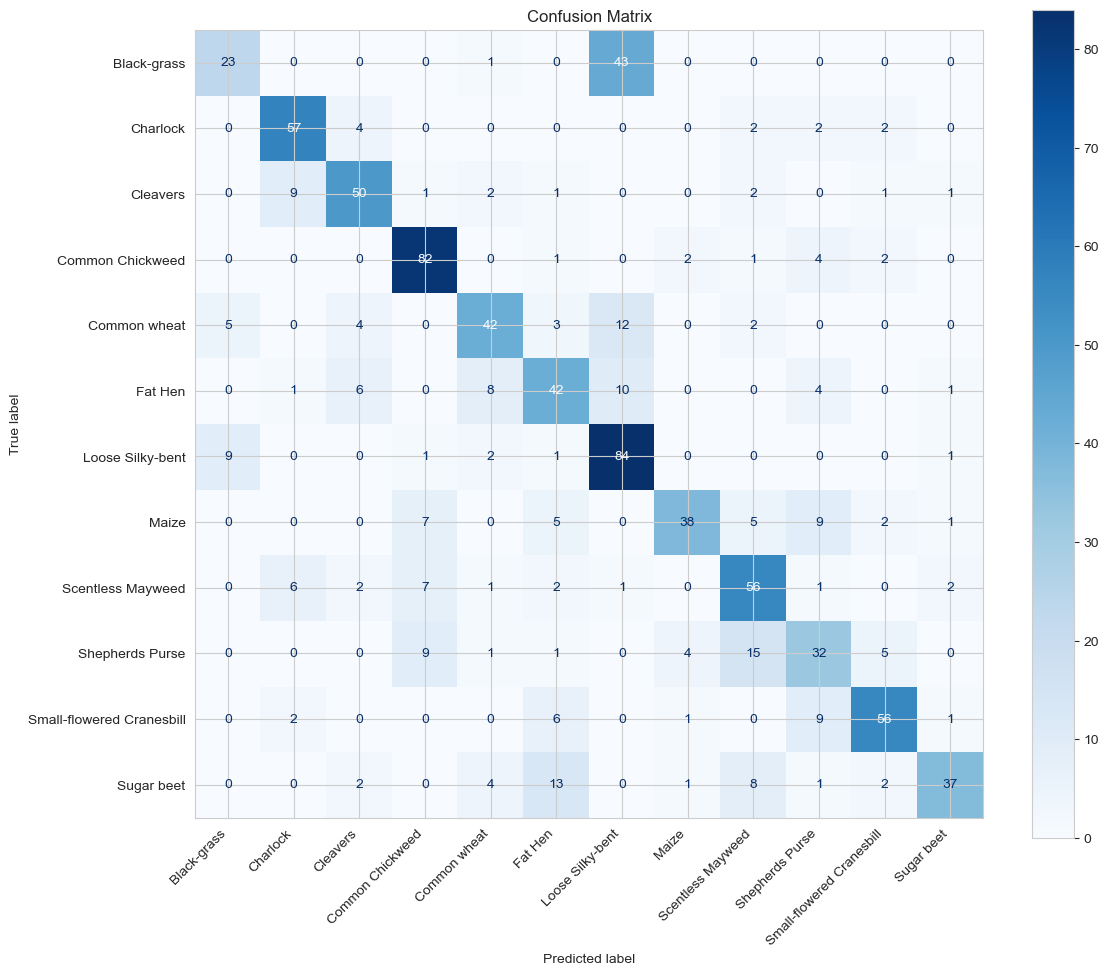

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#generating predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

#creating confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

#adjusting figure size and displaying the confusion matrix
fig, ax = plt.subplots(figsize=(12, 10)) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=45, ha='right')  
plt.title("Confusion Matrix")
plt.tight_layout()  
plt.show()

<p>In this code, I created a confusion matrix for the CNN model to visualize how well it classifies each plant species. First, I generated probability predictions for test images using the predict() function. Then, I converted the predicted probabilities and one-hot encoded true labels into class indices using the argmax() function. Next, I created a confusion matrix to compare true and predicted labels. Finally, I used the ConfusionMatrixDisplay() function to create a visualization of the confusion matrix and labeled the rows and columns with class names instead of indices.</p>

<p>In the confusion matrix visualization, classes like Common Chickweed (82), Loose Silky-bent (84), Scentless Mayweed (56), Small-flowered Cranesbill (56), and Charlock (57) have strong diagonal values, which means the model correctly classifies them most of the time. However, there are also some classes that show significant misclassifications, as seen in the off-diagonal cells. For example, the model misclassifies a significant number of Black-grass samples as Loose Silk-bent (43). The model also struggles with Shepherds purse, with many misclassifications spread across other classes. These misclassifications are likely due to some plant species having similar shapes or textures.</p>

### F1a. Discuss the impact of using stopping criteria to include defining the number of epochs, including a screenshot showing the final training epoch 

<p>The stopping criteria that I used for my CNN model is early stopping because it reduces overfitting by automatically stopping training when validation loss stops improving after a certain number of epochs. The model was originally set to train for 50 epochs, but early stopping stopped training after 17 epochs, as validation loss stopped improving significantly. This can be seen in the later epochs (14-17), where validation loss started increasing slightly from 1.0242 to 1.1205. Early stopping helped optimize training by preventing overfitting and saving computational resources by stopping training after 17 epochs instead of running all 50 epochs. Setting 50 epochs as the maximum was still important, as it ensured that early stopping had flexibility without cutting training too soon. </p>

In [15]:
#getting the final training epoch
final_epoch = len(history.history['loss'])
print(f"Final Training Epoch: {final_epoch}")

#displaying metrics for the final epoch
print(f"Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")

Final Training Epoch: 17
Training Accuracy: 0.7369
Training Loss: 0.6981
Validation Accuracy: 0.6780
Validation Loss: 1.1205


<p>At Epoch 17 (the final training epoch), the CNN model achieved a training accuracy of 73%, training loss of 0.69, validation accuracy of 67%, and validation loss of 1.12. The validation accuracy is slightly lower than the training accuracy, which suggests good generalization without significant overfitting. Early stopping stopped training at Epoch 17, which was a good stopping point for this CNN model to prevent overfitting and unnecessary training.</p>

### F1b. Compare the training data to the validation dataset using an evaluation metric such as loss, accuracy, F1, or mean absolute error (MAE) to assess model performance. Include an explanation.

In [16]:
from sklearn.metrics import accuracy_score, f1_score

#evaluating the model on training and validation datasets
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

#generating predictions for training and validation datasets
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

#converting predictions into class indices
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

#converting one-hot encoded true labels into class indices
y_train_true = np.argmax(y_train, axis=1)
y_val_true = np.argmax(y_val, axis=1)

#computing F1-scores for training and validation datasets
train_f1 = f1_score(y_train_true, y_train_pred_classes, average="weighted")
val_f1 = f1_score(y_val_true, y_val_pred_classes, average="weighted")

print(f"Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
print(f"Training F1-score: {train_f1:.4f}, Validation F1-score: {val_f1:.4f}")

130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Training Accuracy: 0.8521, Validation Accuracy: 0.6757
Training Loss: 0.4959, Validation Loss: 1.0242
Training F1-score: 0.8488, Validation F1-score: 0.6685


<p>In this code, I evaluated the CNN model's performance on both training and validation datasets using accuracy, loss, and F1 scores as metrics. First, I computed the model's loss and accuracy on both training and validation sets using the evaluate() function. The evaluate() function works differently from history.history because it recalculates metrics on the entire dataset after training using the model's final weights, while history.history records metrics batch-by-batch during training and logs the final epoch's values, which may not fully reflect the model's true final performance. Next, I generated predicted probabilities for each class for all samples in the training and validation datasets using the predict() function. Then, I converted both the predicted probabilities and the one-hot encoded true labels into class indices using the argmax() function. Finally, I computed the F1-score for both training and validation datasets using the f1_score() function with a "weighted" average to consider the number of samples per class.</p>

<p>The CNN model achieved training accuracy of 85%, training loss of 0.49, training F1-score of 0.84, validation accuracy of 67%, validation loss of 1.02, and validation F1-score of 0.66. The model performed better on the training data than on the validation data, as it correctly classified a higher percentage of training samples (85% vs. 67%), had a lower training loss (0.49 vs 1.02), and had a higher F1-score (0.84 vs. 066) that indicates precision and recall were more balanced across all classes in the training set compared to the validation set. The noticeable gap between training accuracy and validation accuracy suggests some overfitting, which is further supported by the difference between training loss and validation loss. </p>

### F1c. Provide a visualization comparing the model's training versus validation loss. Include a screenshot

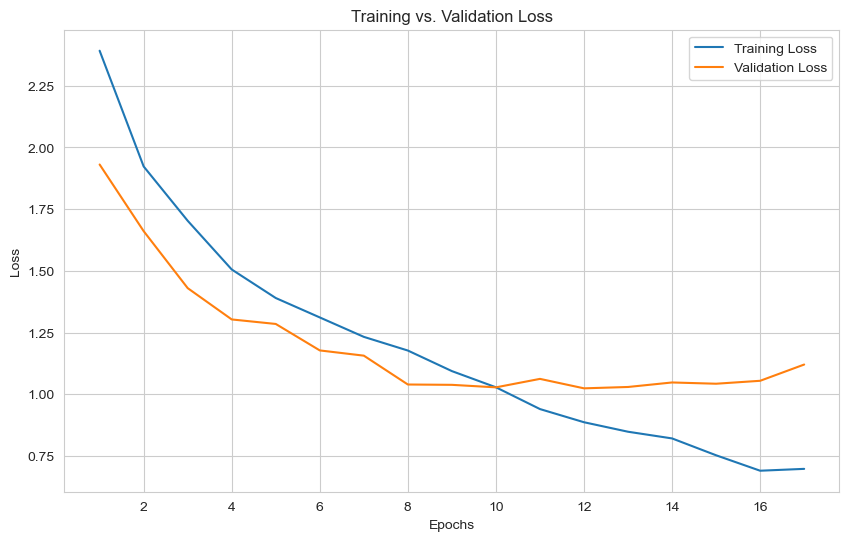

In [17]:
import matplotlib.pyplot as plt

#extracting training loss and validation loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

#defining epoch range
epochs = range(1, len(train_loss) + 1)

#plotting the training loss and validation loss against the number of epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Training Loss")  
plt.plot(epochs, val_loss, label="Validation Loss")  
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

<p>In this code, I created a visualization comparing the training loss and validation loss across epochs for the CNN model. First, I extracted the training loss and validation loss from history.history, which was recorded during training. Then, I defined the epoch range from 1 to the final epoch. Finally, I plotted the training loss and validation loss against the number of epochs.</p>

<p>The training loss decreases steadily across all epochs, showing that the model is learning well on the training data. The validation loss decreases initially, but after Epoch 12, it begins to flatten and slightly increase until the final epoch. There is a noticeable gap between the training loss and validation loss at Epoch 17, which suggests that while the model performs well on training data, it struggles with unseen validation data. This is usually a sign of overfitting.</p>

### F2. Assess the fitness of the model and any actions taken to address overfitting or underfitting

Final Training Epoch: 17
Training Accuracy: 0.7369
Training Loss: 0.6981
Validation Accuracy: 0.6780
Validation Loss: 1.1205


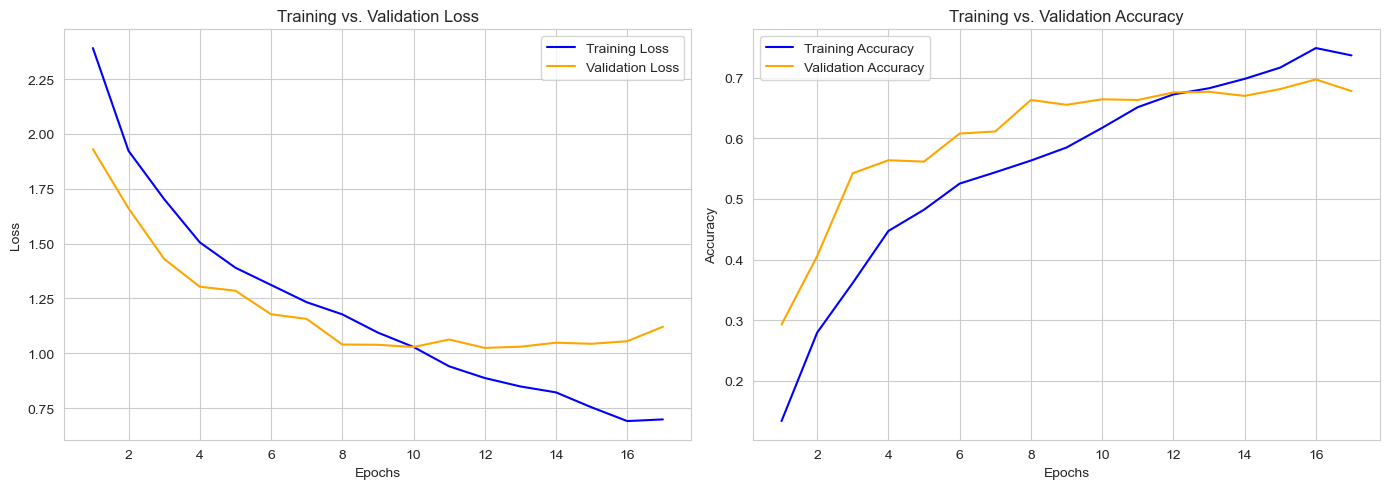

In [18]:
import matplotlib.pyplot as plt

#getting the final training epoch
final_epoch = len(history.history['loss'])
print(f"Final Training Epoch: {final_epoch}")

#displaying metrics for the final epoch
print(f"Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")

#extracting loss and accuracy values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(14, 5))

#plotting the training loss and validation loss against the number of epochs
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Training Loss", color='blue')
plt.plot(epochs, val_loss, label="Validation Loss", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)

#plotting the training accuracy and validation accuracy against the number of epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Training Accuracy", color='blue')
plt.plot(epochs, val_acc, label="Validation Accuracy", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

<p>In the Training vs. Validation Loss visualization, the training loss decreases steadily across all epochs, indicating that the model is learning effectively on the training data. The validation loss initially decreases but starts to flatten around Epoch 12 and then slowly increases until the final epoch. At Epoch 17, a noticeable gap between training (0.69) and validation (1.12) loss suggests that while the model performs well on the training data, it struggles to generalize equally well to unseen validation data. This is usually a sign of overfitting. </p>

<p>In the Training vs. Validation Accuracy visualization, the training accuracy increases steadily across all epochs, showing that the model is improving at classifying training samples. The validation accuracy increases rapidly in early epochs but starts to flatten after Epoch 12. At Epoch 17, training accuracy reaches 73%, while validation accuracy is 67%. The model still generalizes fairly well, but the small performance gap further supports signs of overfitting. </p>

<p>To reduce overfitting, I used early stopping, which stopped training at Epoch 17 when validation loss stopped improving. This prevented unnecessary training and reduced memorization of the training data. I also performed data augmentation earlier to create variations of training images and address class imbalance. This helped the model generalize better by exposing it to a wider range of examples. Additionally, I added a Dropout layer to the CNN model, which helped prevent over-reliance on specific features, improving generalization. I also experimented with different learning rates and batch sizes but found that my current values provided the best balance of accuracy and efficiency, as other values required more epochs without significantly improving the model's performance.</p>

### F3. Discuss the predictive accuracy of the trained network using the test set and the chosen evaluation metric from part F1b

In [19]:
#evaluating the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

#generating predictions for the test set
y_test_pred = model.predict(X_test)

#converting predictions into class indices
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

#converting one-hot encoded true labels into class indices
y_test_true = np.argmax(y_test, axis=1)

#computing F1-score for the test set
test_f1 = f1_score(y_test_true, y_test_pred_classes, average="weighted")

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test F1-score: {test_f1:.4f}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
Test Accuracy: 0.6761
Test Loss: 0.9386
Test F1-score: 0.6699


<p>In this code, I evaluated the CNN model's performance on the test set using accuracy, loss, and F1-score as metrics. First, I computed the model's loss and accuracy on the test set using the evaluate() function. Next, I generated predicted probabilities for each class for all samples in the test set using the predict() function. Then, I converted both the predicted probabilities and the one-hot encoded true labels into class indices using the argmax() function. Finally, I computed the F1-score for the test set using the f1_score() function with a "weighted" average to consider the number of samples per class.</p>

<p>The CNN model achieved a test accuracy of 67%, test loss of 0.93, and test F1-score of 0.66. The 67% test accuracy means the model correctly classified 67% of test samples. Since the test accuracy (67.61%) is very close to the validation accuracy (67.57%), it suggests that the model generalizes consistently to unseen data. However, the test accuracy is much lower than the training accuracy (85%), indicating overfitting during training. The test loss is 0.93, which measures how well predictions match actual labels, and lower loss means better predictions. The test loss (0.93) is lower than validation loss (1.0242) but still higher than training loss (0.4959). This confirms that while the model generalizes reasonably well, it performs significantly better on training data, further supporting signs of overfitting. The test F1-score (0.6699) is almost identical to the validation F1-score (0.6685), which indicates that precision and recall are balanced across classes for unseen data. However, the training F1-score (0.84) is much higher, which aligns with the observed overfitting. Overall, the CNN model generalizes well to unseen data since its test accuracy, loss, and F1-score closely match validation values. However, some overfitting is still present, as seen in the noticeable gap between training and test metrics.</p>

### G1. Provide the code you used to save the trained network within the neural network

In [20]:
#saving the trained model
model.save("cnn_plant_seedling_model.h5")

<p>In this code, I saved the trained CNN model using the save() function. The file "cnn_plant_seedling_model.h5" is in HDf5 (.h5) format and it contains the CNN model including its architecture, trained weights, and optimizer state.</p>

### G2. Discuss the functionality of your neural network, including the impact of the network architecture

<p>The Convolutional Neural Network (CNN) was designed for image classification, specifically to identify plant seedlings across 12 distinct categories. It achieves this by detecting spatial hierarchies in images and recognizing key patterns such as edges, shapes, and textures that differentiate plant species. The CNN architecture directly affects its performance. The two convolutional layers extract spatial features like edges, shapes, and textures, which are essential for distinguishing plant species. The ReLU activation function in the convolutional and dense layers improves learning efficiency by preventing vanishing gradients. The two pooling layers retain important features while removing redundant details, making the model more efficient. The flatten layer connects feature extraction to classification, allowing the dense layers to process high-dimensional data. The first dense layer learns complex patterns from extracted features, while the output dense layer uses the softmax activation function to assign probabilities to each class. The dropout layer helps prevent overfitting by randomly dropping neurons during training, which forces the model to learn generalized features instead of memorizing training data.</p>

<p>It is worth noting that the CNN model's performance depends not only on its architecture but also on its training and optimization process. The model was trained using the plant dataset, which had been augmented and normalized to handle class imbalance and speed up convergence. It used categorical cross-entropy as the loss function, which is well-suited for this task, as it involves multi-class classification with 12 classes. It also used the Adam optimizer with a learning rate of 0.001 to efficiently adjust weights and minimize loss throughout training. I applied early stopping to stop training when validation loss stopped improving, preventing overfitting and reducing unnecessary computation.</p>

<p>The CNN model's architecture and its optimization settings enabled it to achieve a training accuracy of 85%, validation accuracy of 67%, test accuracy of 67%, training loss of 0.49, validation loss of 1.02, and test loss of 0.93. The model performs well and generalizes consistently to unseen data, as test metrics closely match validation metrics. However, the noticeable gap between training and test metrics suggests some overfitting. Overall, the CNN model's architecture and its optimization settings provide strong performance, though further tuning could help reduce overfitting.</p>

### G3. Discuss the effectiveness of the model in addressing the business problem you identified in part A1

<p>The CNN model achieved test accuracy of 67%, test loss of 0.93, and test F1-score of 0.66. Based on these test metrics, the model shows moderate effectiveness in classifying plant seedlings into distinct categories, including crops and weeds. It can help farmers by automating crop and weed identification, reducing errors in weed control and the need for manual work. Also, the similarity between test accuracy (67.61%) and validation accuracy (67.57%) suggests that the model generalizes well to unseen data, making it potentially useful for real-world weed detection systems. However, some limitations remain. The 67% test accuracy suggests that the model still misclassifies some seedlings, which means it may not be fully reliable for high-precision farming applications. Also, the gap between training accuracy (85%) and test accuracy (67%) suggests overfitting, which means the model may not perform as well in real-world farming conditions where plants vary. Overall, The CNN model provides a strong foundation for automated seedling classification but needs improvements to be fully reliable for real-world farming.</p>

### G4. Discuss lessons learned including how the model might be improved (i.e., if you were to deploy this model in a real-life scenario)

<p>I have learned several key lessons when developing and evaluating the CNN model for plant seedling classification. First, the gap between training accuracy (85%) and test accuracy (67%) indicates overfitting, where the model performs well on training data but struggles with unseen data. This highlights the importance of regularization techniques like dropout, early stopping, and data augmentation to improve generalization. If I did not apply these techniques, the test accuracy would likely be lower than 67%, with an even larger gap from the training accuracy. Second, the test F1-score of 0.66 indicates that some plant classes were harder to classify. This can be seen in the confusion matrix, where many misclassifications occurred, showing the model struggles with visually similar plant species. This highlights the importance of data augmentation in addressing class imbalance, which is crucial for improving performance. Earlier, I applied data augmentation by increasing the number of samples for minority classes to ensure they were well-represented. Without data augmentation, misclassifications in the confusion matrix would likely be much worse. Third, the 67% test accuracy means the model still misclassifies some seedlings, which could cause incorrect weed removal or crop damage in agriculture. This highlights the need for higher accuracy, especially in high-precision farming applications.</p>

<p> The model can be improved in several ways for real-world deployment. First, expanding the dataset with more plant images from actual farming environments would help the model learn different variations and improve its accuracy in real-world conditions. Second, using a deeper CNN with more convolutional layers could help the model capture finer details in plant structures. Third, increasing the dropout rate from 0.5 to 0.6 or 0.7 could further reduce overfitting by forcing the model to rely on more generalized patterns. Finally, implementing transfer learning with pre-trained models trained on large datasets could improve accuracy while reducing the need for training a CNN from scratch. </p>

### G5. Recommend a course of action based on your results as they relate to the research question

<p>Based on the model's test accuracy (67%), test loss (0.93), and test F1-score (0.66), the CNN model shows moderate effectiveness in classifying plant seedlings and can serve as a foundation for an automated weed detection system. However, its current performance may not be sufficient for real-world farming, where high precision is needed to prevent misclassifying crops as weeds or missing weeds entirely. To make the model more effective for real-world deployment, one recommended action is to collect more plant images from actual farming environments with varying lighting and angles to improve generalization. Another recommended action is to implement transfer learning using pre-trained models trained on large datasets, which can improve accuracy without requiring training a CNN from scratch. Once the model's performance improves with these techniques, it can be deployed on farms and integrated with automated systems like smart cameras for real-time weed detection. This would ultimately help farmers optimize yields, reduce manual labor, and improve weed management efficiency.</p>

### H. Submit a copy of your code used to save the trained network within the neural network and output in a PDF or HTML format.

<p>The code that I used to save the trained network is in <b>d604task1rough.html</b>. I included this file for submission.</p>

### I. Submit a list of all the specific web sources you used to acquire segments of third-party code to support the application
<pre>
Dutta, S. (2023, May 27). <i>Designing Your Own Convolutional Neural Network (CNN) Model: A Step-by-Step Guide for Beginners.</i> Medium. https://medium.com/@sanjay_dutta/designing-your-own-convolutional-neural-network-cnn-model-a-step-by-step-guide-for-beginners-4e8b57836c81 

Sharma, A. (2017, December 5). <i>Convolutional Neural Networks in Python with Keras.</i> DataCamp. https://www.datacamp.com/tutorial/convolutional-neural-networks-python 

Sikhwal, A. (2024, June 25). <i>Image Data Augmentation Using Keras API ImageDataGenerator.</i> CloudThat Resources. https://www.cloudthat.com/resources/blog/image-data-augmentation-using-keras-api-imagedatagenerator 
</pre>

### J. Acknowledge sources, using in-text citations and references, for content that is quoted, paraphrased, or summarized

<pre>
Ayush. (2025, March 10). <i>Optimizers in Deep learning: A Detailed Guide.</i> Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/ 

Dutta, S. (2024, October 6). <i>Understanding the Convolutional Layer in Convolutional Neural Networks (CNNs).</i> Medium. https://medium.com/@sanjay_dutta/understanding-the-convolutional-layer-in-convolutional-neural-networks-cnns-ef4065a0e3ca#:~:text=First%20Convolutional%20Layer%3A%20In%20the,cat%2C%20car%2C%20or%20tree.

Nyandwi, J. de D. (2021, November 21). <i>Early Stopping Explained!.</i> Jean de Dieu Nyandwi. https://jeande.hashnode.dev/early-stopping-explained 

Parti, A. (2024, June 11). <i>Understanding Activation Functions in Neural Networks.</i> Pareto. https://pareto.ai/blog/activation-function-in-neural-networks 

Qureshi, A. (2024, August 11). <i>Dive into 1D CNNS: Simplifying Complex Sequential Data.</i> LinkedIn. https://www.linkedin.com/pulse/dive-1d-cnns-simplifying-complex-sequential-data-arslan-qureshi-dgbif 

Verma, A. (2024, December 24). <i>What is Dropout Regularization in Deep Learning?.</i> Pickl.AI. https://www.pickl.ai/blog/what-is-dropout-regularization-in-deep-learning/ 
</pre>